In [1]:
import gc
from datetime import datetime, timedelta
import dateutil.relativedelta
import json
from zipfile import ZipFile
from collections import Counter

import pandas as pd
from pandas.io.json import json_normalize
from scipy.ndimage.interpolation import shift
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [2]:
PATH_TO_DATA = 'data/all.zip'

In [3]:
pd.set_option('max_columns', 100)

_____

In [4]:
def read_zip(zipfile, file, **kwards):
    with ZipFile(zipfile) as zip_file:
        with zip_file.open(file) as myfile:
            data = pd.read_csv(myfile, **kwards)
    return data

In [5]:
def timestamp_to_str(df_column):
    convert_dict = {
        el: datetime.utcfromtimestamp(int(el))
        for el in df_column.unique()
    }
    return df_column.map(convert_dict)

In [6]:
def json_to_df(train, json_cols):
    df = train[json_cols]
    for col in json_cols:
        df[col] = df[col].apply(json.loads)
    df.reset_index(inplace=True)
    df = json_normalize(df.to_dict(orient='records')).replace('not available in demo dataset', np.nan)
    train = train.merge(df, left_index=True, right_on='index', how='left')
    train.drop('index', axis=1, inplace=True)
    del df
    gc.collect()
    return train

In [7]:
def return_bad_cols(train):
    bad_cols = train.nunique(dropna=False)
    bad_cols = bad_cols[bad_cols==1].index.tolist()
    return bad_cols

In [8]:
def show_uniques(data):
    for col in data.columns:
        print(f'---{col}---\n', data[col].unique(), sep='')
        print()

In [9]:
def return_holidays(data, start_trest, finish_test):
    holidays = data[
        ['totals.transactionRevenue', 'geoNetwork.country', 'date']
    ].fillna(0).groupby(['geoNetwork.country', 'date'])['totals.transactionRevenue'].sum()
    holidays = holidays.reset_index()
    holidays = holidays[
        holidays['geoNetwork.country'].isin(
            holidays.groupby('geoNetwork.country')['totals.transactionRevenue'].sum()[
                holidays.groupby('geoNetwork.country')['totals.transactionRevenue'].sum()>0].index)
    ]
    holidays = holidays[holidays['totals.transactionRevenue']>0]
    holidays['month'] = holidays.date.apply(lambda x: x.month)
    holidays['target'] = holidays['totals.transactionRevenue'].apply(np.log1p)
    ags = holidays.groupby('geoNetwork.country')['target'].agg(['mean', 'std']).reset_index().fillna(0)
    ags['border'] = ags['mean'] -2*ags['std']
    holidays = holidays.merge(ags[['geoNetwork.country', 'border']], on='geoNetwork.country',how='left').fillna(0)
    holidays = holidays[holidays['target']>=holidays['border']]
    del ags
    holidays = holidays.groupby(['geoNetwork.country', 'month']).size().reset_index().rename(columns={0:'holcnts'})
    holidays = holidays[holidays.month.isin([start_trest.month, finish_test.month])].groupby('geoNetwork.country',
                                                                                             as_index=False)['holcnts'].sum()
    return holidays

In [10]:
def get_datasets(start_train, finish_train, start_trest, finish_test, data):
    train = data[(data.date>=start_train)&(data.date<=finish_train)]

    test = data[(data.date>=start_trest)&(data.date<=finish_test)]
    test = test[test.fullVisitorId.isin(train.fullVisitorId.unique())]
    
    target = test[['fullVisitorId', 'totals.transactionRevenue']].fillna(0).groupby('fullVisitorId').sum().reset_index()
    target.rename(columns={'totals.transactionRevenue': 'target'}, inplace=True)
    target['target'] = np.log1p(target['target'])

    history = data[(data.date<=finish_train)&(data.fullVisitorId.isin(train.fullVisitorId.unique()))]
    
    return train, test, target, history

# Разведка

In [11]:
train = read_zip(PATH_TO_DATA, 'train_v2.csv')

/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [95]:
test = read_zip(PATH_TO_DATA, 'test_v2.csv')

/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [90]:
sample_submission = read_zip(PATH_TO_DATA, 'sample_submission_v2.csv')

/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [13]:
json_cols = ['device', 'geoNetwork', 'totals', 'trafficSource']

In [14]:
train = json_to_df(train, json_cols)
test = json_to_df(test, json_cols)

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [15]:
train['posix_date'] = timestamp_to_str(train.visitStartTime)
test['posix_date'] = timestamp_to_str(test.visitStartTime)

In [16]:
train['fullVisitorId'] = train['fullVisitorId'].astype('str')
test['fullVisitorId'] = test['fullVisitorId'].astype('str')
train['totals.transactionRevenue'] = train['totals.transactionRevenue'].astype('float')
test['totals.transactionRevenue'] = test['totals.transactionRevenue'].astype('float')

In [17]:
def make_hist(test):
    dist = test[['fullVisitorId', 'totals.transactionRevenue']].fillna(0).groupby('fullVisitorId').sum()
    dist['target'] = dist['totals.transactionRevenue'].apply(np.log1p)
    hist = np.histogram(dist['target'], bins='doane')
    return hist

In [18]:
hist_test = make_hist(test)

In [19]:
hist_train = make_hist(train[(train.date.astype('str')>='20170501')&(train.date.astype('str')<='20171015')])

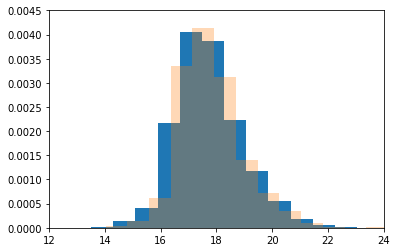

In [20]:
plt.bar(hist_train[1][:-1], hist_train[0]/hist_train[0].sum(), hist_train[1][1], align = 'edge')
plt.bar(hist_test[1][:-1], hist_test[0]/hist_test[0].sum(), hist_test[1][1], align = 'edge', alpha=0.3)
plt.xlim([12, 24])
plt.ylim([0, 0.0045])
plt.show()

In [21]:
hist_train[0].sum() - hist_train[0][0]

4935

In [22]:
hist_test[0].sum() - hist_test[0][0]

4163

In [23]:
t1 = train[(train.date.astype('str')>='20170501')&(train.date.astype('str')<='20171015')]
t1 = t1[['fullVisitorId', 'totals.transactionRevenue']].fillna(0).groupby('fullVisitorId').sum()
t1 = t1.reset_index()
t1.rename(columns={'totals.transactionRevenue':'1'}, inplace=True)
t1['1'] = t1['1'].apply(np.log1p)

t2 = train[(train.date.astype('str')>='20171201')&(train.date.astype('str')<='20180131')]
t2 = t2[['fullVisitorId', 'totals.transactionRevenue']].fillna(0).groupby('fullVisitorId').sum()
t2 = t2.reset_index()
t2.rename(columns={'totals.transactionRevenue':'2'}, inplace=True)
t2['2'] = t2['2'].apply(np.log1p)

In [24]:
len(set(t1.fullVisitorId) | set(t2.fullVisitorId))

474148

In [25]:
t0 = t1.merge(t2, on='fullVisitorId', how='left').fillna(0)

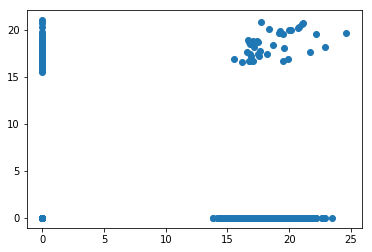

In [26]:
#plt.scatter(t0[t0['1']!=0]['1'], t0[t0['1']!=0]['2'])
plt.scatter(t0['1'], t0['2'])
plt.show()

In [27]:
np.corrcoef(t0[t0['1']!=0]['1'], t0[t0['1']!=0]['2'], )

array([[1.        , 0.07655954],
       [0.07655954, 1.        ]])

In [28]:
set(train.columns) - set(test.columns), set(test.columns) - set(train.columns)

({'trafficSource.campaignCode'}, set())

In [29]:
train['trafficSource.campaignCode'].unique()

array([nan, '11251kjhkvahf'], dtype=object)

In [30]:
train_bad_cols = return_bad_cols(train)
test_bad_cols = return_bad_cols(test)

In [31]:
set(train_bad_cols) - set(test_bad_cols), set(test_bad_cols) - set(train_bad_cols)

(set(), set())

In [32]:
bad_cols = list(set(train_bad_cols + test_bad_cols))
del train_bad_cols, test_bad_cols
bad_cols 

['device.mobileDeviceInfo',
 'device.browserSize',
 'device.browserVersion',
 'socialEngagementType',
 'device.mobileDeviceBranding',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.language',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters',
 'device.screenResolution',
 'geoNetwork.latitude',
 'device.mobileDeviceModel',
 'device.flashVersion',
 'device.screenColors',
 'geoNetwork.cityId',
 'geoNetwork.longitude',
 'device.mobileDeviceMarketingName',
 'geoNetwork.networkLocation']

In [33]:
bad_cols.append('trafficSource.campaignCode')

In [34]:
train['customDimensions'].value_counts()

[{'index': '4', 'value': 'North America'}]      768223
[]                                              333235
[{'index': '4', 'value': 'EMEA'}]               313991
[{'index': '4', 'value': 'APAC'}]               222071
[{'index': '4', 'value': 'South America'}]       45553
[{'index': '4', 'value': 'Central America'}]     25264
Name: customDimensions, dtype: int64

In [35]:
test['customDimensions'].value_counts()

[{'index': '4', 'value': 'North America'}]      193825
[{'index': '4', 'value': 'EMEA'}]                69929
[{'index': '4', 'value': 'APAC'}]                63088
[]                                               60581
[{'index': '4', 'value': 'South America'}]        9565
[{'index': '4', 'value': 'Central America'}]      4601
Name: customDimensions, dtype: int64

In [36]:
bad_cols = bad_cols + json_cols
len(bad_cols)

24

In [37]:
train['is_test'] = 0
test['is_test'] = 1

In [38]:
train.head().shape

(5, 66)

In [39]:
data = pd.concat([train, test])

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [40]:
good_cols = [col for col in data.columns if col not in bad_cols]
good_cols.remove('hits')

In [41]:
data[good_cols]

,channelGrouping,customDimensions,date,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,fullVisitorId,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,is_test,posix_date,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.totalTransactionRevenue,totals.transactionRevenue,totals.transactions,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,visitId,visitNumber,visitStartTime
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,Firefox,desktop,False,Windows,3162355547410993243,NaN,Europe,Germany,NaN,(not set),NaN,Western Europe,0,2017-10-17 00:00:50,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,water bottle,organic,NaN,google,1508198450,1,1508198450
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,Chrome,desktop,False,Chrome OS,8934116514970143966,Cupertino,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,0,2017-10-16 17:51:47,NaN,2,NaN,2,2,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com,1508176307,6,1508176307
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,Chrome,mobile,True,Android,7992466427990357681,NaN,Americas,United States,NaN,windjammercable.net,NaN,Northern America,0,2017-10-17 00:53:33,NaN,2,1,2,1,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),True,NaN,(none),NaN,(direct),1508201613,1,1508201613
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,Chrome,desktop,False,Windows,9075655783635761930,NaN,Asia,Turkey,NaN,unknown.unknown,NaN,Western Asia,0,2017-10-16 16:04:11,NaN,2,1,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,1508169851,1,1508169851
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,Chrome,desktop,False,Windows,6960673291025684308,NaN,Americas,Mexico,NaN,prod-infinitum.com.mx,NaN,Central America,0,2017-10-16 21:49:12,NaN,2,1,2,1,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,1508190552,1,1508190552
5,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,Chrome,desktop,False,Macintosh,0166277907528479249,San Francisco,Americas,United States,San Francisco-Oakland-San Jose CA,unknown.unknown,California,Northern America,0,2017-10-16 23:31:41,NaN,2,1,2,2,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(none),/offer/2145,(direct),1508196701,1,1508196701
6,Referral,"[{'index': '4', 'value': 'EMEA'}]",20171016,Chrome,desktop,False,Macintosh,8349655975937271469,London,Europe,United Kingdom,London,(not set),England,Northern Europe,0,2017-10-16 11:14:38,NaN,2,1,2,1,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,referral,/a/google.com/nest-vision/dropcam-field-tester...,sites.google.com,1508152478,1,1508152478
7,Organic Search,[],20171016,Chrome,desktop,False,Windows,1332629902468998662,NaN,Europe,Denmark,NaN,fullrate.ninja,NaN,Northern Europe,0,2017-10-17 02:10:08,NaN,2,1,2,1,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,1508206208,1,1508206208
8,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,Chrome,desktop,False,Macintosh,632878546807742341,Mexico City,Americas,Mexico,(not set),uninet-ide.com.mx,Mexico City,Central America,0,2017-10-17 02:31:56,NaN,2,1,2,1,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,1508207516,1,1508207516
9,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,Safari,mobile,True,iO

In [42]:
t = train['fullVisitorId']
t.drop_duplicates(inplace=True)

In [43]:
t = t.reset_index().rename(columns={'index':'in_train'})
t['in_train'] = 1

In [44]:
t= test[['fullVisitorId', 'totals.transactionRevenue']].fillna(0).groupby('fullVisitorId')['totals.transactionRevenue'].sum().reset_index().merge(t, on='fullVisitorId', how='left').fillna(0)

In [45]:
t['not_zero_rev'] = np.where(t['totals.transactionRevenue']>0, 1, 0)

In [46]:
pd.crosstab(index=t['in_train'], columns=t['not_zero_rev'])

not_zero_rev,0,1
in_train,,
0.0,291131,4048
1.0,2570,115


# Чистим

In [47]:
data.date = data.date.astype('str')

In [48]:
show_uniques(data[good_cols])

---channelGrouping---
['Organic Search' 'Referral' 'Direct' 'Paid Search' 'Display' 'Affiliates'
 'Social' '(Other)']

---customDimensions---
["[{'index': '4', 'value': 'EMEA'}]"
 "[{'index': '4', 'value': 'North America'}]"
 "[{'index': '4', 'value': 'Central America'}]" '[]'
 "[{'index': '4', 'value': 'APAC'}]"
 "[{'index': '4', 'value': 'South America'}]"]

---date---
['20171016' '20160902' '20171130' '20170126' '20170623' '20170312'
 '20170203' '20180415' '20171110' '20160811' '20170613' '20170113'
 '20171111' '20161118' '20161110' '20161112' '20170621' '20180117'
 '20180103' '20161123' '20180120' '20180307' '20180429' '20170501'
 '20170611' '20170630' '20161213' '20180211' '20180221' '20171030'
 '20170519' '20180316' '20170111' '20170624' '20161014' '20170914'
 '20171006' '20170529' '20180203' '20170515' '20170420' '20160831'
 '20171007' '20170801' '20170228' '20161209' '20160917' '20180413'
 '20170617' '20180204' '20161216' '20160820' '20170616' '20171115'
 '20180119' '20180402' 

---device.browser---
['Firefox' 'Chrome' 'Safari' 'UC Browser' 'Internet Explorer' 'Edge'
 'Samsung Internet' 'Android Webview' 'Safari (in-app)' 'Opera Mini'
 'Opera' 'YaBrowser' 'Amazon Silk' 'Mozilla Compatible Agent' 'Puffin'
 'Maxthon' 'BlackBerry' 'ADM' 'Coc Coc' 'MRCHROME' 'Android Browser'
 'Playstation Vita Browser' 'Nintendo Browser' 'Nokia Browser' 'SeaMonkey'
 'Lunascape' 'IE with Chrome Frame' 'ThumbSniper' 'LYF_LS_4002_12'
 'DESKTOP' 'Mozilla' 'Browser' 'osee2unifiedRelease' 'Seznam' '(not set)'
 ';__CT_JOB_ID__:65da7e5f-0f05-4b5d-8d31-1f4d470a2b82;' 'Apple-iPhone7C2'
 ';__CT_JOB_ID__:a80e8e16-6e98-455b-885a-a4dd40f3d344;'
 ';__CT_JOB_ID__:89e59554-ad41-4e94-957b-f12bd012530c;'
 'DDG-Android-3.1.1' 'NokiaE52-1' 'Iron'
 '[Use default User-agent string] LIVRENPOCHE' 'Konqueror'
 ';__CT_JOB_ID__:7e575295-571e-4e82-9254-7f2c8bbb9183;' 'LYF_LS_4002_11'
 'M5' 'Android Runtime' 'Changa 99695759' 'YE' 'no-ua' '+Simple Browser'
 'MQQBrowser' 'Nichrome' 'tfowdqmibyshaklxuregpcnzvj'

---geoNetwork.metro---
[nan 'San Francisco-Oakland-San Jose CA' 'London' '(not set)' 'JP_KANTO'
 'Los Angeles CA' 'Pittsburgh PA' 'Detroit MI' 'Boston MA-Manchester NH'
 'New York NY' 'Seattle-Tacoma WA' 'Washington DC (Hagerstown MD)'
 'San Antonio TX' 'Atlanta GA' 'Chicago IL' 'Dallas-Ft. Worth TX'
 'Philadelphia PA' 'San Diego CA' 'Austin TX' 'Nashville TN' 'Houston TX'
 'Yorkshire' 'Denver CO' 'Roanoke-Lynchburg VA' 'La Crosse-Eau Claire WI'
 'Charlotte NC' 'Butte-Bozeman MT' 'JP_KINKI' 'Portland OR' 'Phoenix AZ'
 'Columbus OH' 'Minneapolis-St. Paul MN' 'North West' 'Jacksonville FL'
 'Meridian (exc. Channel Islands)' 'Orlando-Daytona Beach-Melbourne FL'
 'Las Vegas NV' 'Midlands' 'Springfield-Holyoke MA'
 'Green Bay-Appleton WI' 'Harlingen-Weslaco-Brownsville-McAllen TX'
 'Indianapolis IN' 'Chico-Redding CA' 'Norfolk-Portsmouth-Newport News VA'
 'East Of England' 'Lansing MI' 'Idaho Falls-Pocatello ID' 'Omaha NE'
 'Salt Lake City UT' 'Miami-Ft. Lauderdale FL' 'Oklahoma City OK'
 '

---geoNetwork.subContinent---
['Western Europe' 'Northern America' 'Western Asia' 'Central America'
 'Northern Europe' 'Southern Asia' 'Southeast Asia' 'Eastern Europe'
 'South America' 'Eastern Asia' 'Southern Europe' 'Australasia'
 'Central Asia' '(not set)' 'Northern Africa' 'Eastern Africa'
 'Southern Africa' 'Western Africa' 'Caribbean' 'Middle Africa'
 'Melanesia' 'Micronesian Region' 'Polynesia']

---is_test---
[0 1]

---posix_date---
['2017-10-17T00:00:50.000000000' '2017-10-16T17:51:47.000000000'
 '2017-10-17T00:53:33.000000000' ... '2018-09-07T20:23:11.000000000'
 '2018-09-07T17:10:17.000000000' '2018-09-07T14:41:41.000000000']

---totals.bounces---
['1' nan]

---totals.hits---
['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30'
 '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '43' '45' '46'
 '47' '50' '52' '56' '58' '62' '66' '69' '74' '75' '85' '90' '93' '94'
 '138' '165' '42' 

---trafficSource.campaign---
['(not set)' '"google + redesign/Accessories March 17" All Users'
 'AW - Dynamic Search Ads Whole Site'
 '1000557 | GA | US | en | Hybrid | GDN Text+Banner | AS'
 'Data Share Promo' 'Page: contains "/google+redesign/bags" All Users'
 '1000557 | GA | US | en | Hybrid | GDN Remarketing'
 'Page: contains "/google+redesign/office"'
 'Page: contains "/google+redesign/drinkware"'
 'Page: contains "/google+redesign/bags" 1 Day' 'AW - Electronics'
 'AW - Accessories' 'Smart Display Campaign'
 '"google + redesign/Accessories March 17" All Users Similar Audiences'
 'Page: contains "/google+redesign/drinkware" Similar Audiences'
 'Run of Network Line Item' 'Technology/Technophiles'
 'Technology/Mobile Enthusiasts' 'Media & Entertainment/Movie Lovers'
 'Media & Entertainment/Music Lovers' 'Lifestyles & Hobbies/Shutterbugs'
 'Sports & Fitness/Health & Fitness Buffs'
 'Page: contains "/google+redesign/office" Similar Audiences'
 'Value Shoppers Affinity' 'AW - Apparel'
 

---visitId---
[1508198450 1508176307 1508201613 ... 1536351791 1536340217 1536331301]

---visitNumber---
[  1   6   2  10   3   4  14  11   7  15  17   5  13  16   8  34  21  18
  28   9  12  29 138  36  30 102  20  54  33  57  19  45  27  39  43  25
  26  23  31  99 100 101  46  24  22  56  83  38  84  42  89 136  85 105
  48  93  50  64  94  70  98 149  72  69  35 124 178  59 317  51 160  52
  63  47  49  88 140  91  92  41  74 309  61  32 108 195 162 235  90  86
 236 158  82 159 148 125  55  66 401  65  40  60  58 137 126 112 155  96
  73  78  97  87  76  77 304 107 106 389  68 132 266 267 221 143 104 142
 245 174 121 175 191 190 189 204  37 206 156 157  62 110 109 184 183 169
 163 150 147 113 164  44 194 193 254  71  53 145 144 146  80 253 222 223
  81 128 192 129 161 152 324 134 135 130  95  75 103 315 154 153 283 117
 181 272 273 118 208 122 287 133 396 115 114 131 202 232 120 262 263 295
 297 298 219 296 141 207 187 170 369 205  79 400 173 172 265 264  67 326
 325 197 167 196 27

In [49]:
data['customDimensions'] = np.where(data['customDimensions']=='[]',
                                    "[{'index': '4', 'value': 'nan'}]",
                                    data['customDimensions'])
data['customDimensions'] = data['customDimensions'].apply(lambda x: x.split(',')[1].split(':')[1].split("'")[1])
data['customDimensions'] = np.where(data['customDimensions']=='nan',
                                    np.nan,
                                    data['customDimensions'])

data['device.isMobile'] = np.where(data['device.isMobile']==True, 1, 0)
data['totals.bounces'] = np.where(data['totals.bounces']=='1', 1, 0)
data['totals.hits'] = data['totals.hits'].astype('int')
data['totals.newVisits'] = np.where(data['totals.newVisits']=='1', 1, 0)
data['totals.pageviews'] = data['totals.pageviews'].astype('float')
data['totals.sessionQualityDim'] = data['totals.sessionQualityDim'].astype('float')
data['totals.timeOnSite'] = data['totals.timeOnSite'].astype('float')
data['totals.totalTransactionRevenue'] = data['totals.totalTransactionRevenue'].astype('float')
data['totals.transactions'] = data['totals.transactions'].astype('float')
data['trafficSource.adwordsClickInfo.isVideoAd'] = np.where(data['trafficSource.adwordsClickInfo.isVideoAd']==False, 0, 1)
data['trafficSource.adwordsClickInfo.page'] = data['trafficSource.adwordsClickInfo.page'].astype('float')
data['trafficSource.isTrueDirect'] = np.where(data['trafficSource.isTrueDirect']==True, 1, 0)

In [50]:
show_uniques(data[good_cols])

---channelGrouping---
['Organic Search' 'Referral' 'Direct' 'Paid Search' 'Display' 'Affiliates'
 'Social' '(Other)']

---customDimensions---
['EMEA' 'North America' 'Central America' nan 'APAC' 'South America']

---date---
['20171016' '20160902' '20171130' '20170126' '20170623' '20170312'
 '20170203' '20180415' '20171110' '20160811' '20170613' '20170113'
 '20171111' '20161118' '20161110' '20161112' '20170621' '20180117'
 '20180103' '20161123' '20180120' '20180307' '20180429' '20170501'
 '20170611' '20170630' '20161213' '20180211' '20180221' '20171030'
 '20170519' '20180316' '20170111' '20170624' '20161014' '20170914'
 '20171006' '20170529' '20180203' '20170515' '20170420' '20160831'
 '20171007' '20170801' '20170228' '20161209' '20160917' '20180413'
 '20170617' '20180204' '20161216' '20160820' '20170616' '20171115'
 '20180119' '20180402' '20160822' '20180107' '20161129' '20170318'
 '20171025' '20180302' '20170822' '20170819' '20161130' '20170303'
 '20160816' '20170820' '20161030' '2016

---device.browser---
['Firefox' 'Chrome' 'Safari' 'UC Browser' 'Internet Explorer' 'Edge'
 'Samsung Internet' 'Android Webview' 'Safari (in-app)' 'Opera Mini'
 'Opera' 'YaBrowser' 'Amazon Silk' 'Mozilla Compatible Agent' 'Puffin'
 'Maxthon' 'BlackBerry' 'ADM' 'Coc Coc' 'MRCHROME' 'Android Browser'
 'Playstation Vita Browser' 'Nintendo Browser' 'Nokia Browser' 'SeaMonkey'
 'Lunascape' 'IE with Chrome Frame' 'ThumbSniper' 'LYF_LS_4002_12'
 'DESKTOP' 'Mozilla' 'Browser' 'osee2unifiedRelease' 'Seznam' '(not set)'
 ';__CT_JOB_ID__:65da7e5f-0f05-4b5d-8d31-1f4d470a2b82;' 'Apple-iPhone7C2'
 ';__CT_JOB_ID__:a80e8e16-6e98-455b-885a-a4dd40f3d344;'
 ';__CT_JOB_ID__:89e59554-ad41-4e94-957b-f12bd012530c;'
 'DDG-Android-3.1.1' 'NokiaE52-1' 'Iron'
 '[Use default User-agent string] LIVRENPOCHE' 'Konqueror'
 ';__CT_JOB_ID__:7e575295-571e-4e82-9254-7f2c8bbb9183;' 'LYF_LS_4002_11'
 'M5' 'Android Runtime' 'Changa 99695759' 'YE' 'no-ua' '+Simple Browser'
 'MQQBrowser' 'Nichrome' 'tfowdqmibyshaklxuregpcnzvj'

---geoNetwork.networkDomain---
['(not set)' 'windjammercable.net' 'unknown.unknown' ...
 'teamsustain456.com' 'robert-aebi.com' 'fatoffice.co.uk']

---geoNetwork.region---
[nan 'California' 'England' 'Mexico City' 'Nevada' 'Brussels' 'Tokyo'
 '(not set)' 'County Dublin' 'Maharashtra' 'Istanbul' 'Ontario'
 'Telangana' 'Pennsylvania' 'Michigan' 'Massachusetts' 'British Columbia'
 'Madhya Pradesh' 'Quebec' 'New South Wales' 'Jakarta' 'New York'
 'State of Sao Paulo' 'Washington' 'District of Columbia' 'Chiayi County'
 'Delhi' 'Karnataka' 'Bangkok' 'Aragon' 'Zurich' 'Masovian Voivodeship'
 'Texas' 'Georgia' 'Illinois' 'Tamil Nadu' 'Sindh' 'Lombardy'
 'Federal Territory of Kuala Lumpur' 'Saint Petersburg' 'Tennessee'
 'Hanoi' 'Taipei City' 'Madrid' 'Berlin' 'Ho Chi Minh City' 'Victoria'
 'Seoul' 'Ile-de-France' 'Lisbon' 'Bogota' 'New Taipei City'
 'Stockholm County' 'Western Province' 'Lagos' 'Riyadh Province' 'Dubai'
 'Colorado' 'Buenos Aires' 'Lima Region' 'Santiago Metropolitan Region'
 

---geoNetwork.subContinent---
['Western Europe' 'Northern America' 'Western Asia' 'Central America'
 'Northern Europe' 'Southern Asia' 'Southeast Asia' 'Eastern Europe'
 'South America' 'Eastern Asia' 'Southern Europe' 'Australasia'
 'Central Asia' '(not set)' 'Northern Africa' 'Eastern Africa'
 'Southern Africa' 'Western Africa' 'Caribbean' 'Middle Africa'
 'Melanesia' 'Micronesian Region' 'Polynesia']

---is_test---
[0 1]

---posix_date---
['2017-10-17T00:00:50.000000000' '2017-10-16T17:51:47.000000000'
 '2017-10-17T00:53:33.000000000' ... '2018-09-07T20:23:11.000000000'
 '2018-09-07T17:10:17.000000000' '2018-09-07T14:41:41.000000000']

---totals.bounces---
[1 0]

---totals.hits---
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  43  45  46  47  50  52  56  58  62  66  69  74  75
  85  90  93  94 138 165  42  44  48  49  51  54  55  57  65  67  72  79
  82  83  92 10

---trafficSource.keyword---
['water bottle' nan '(not provided)' ...
 '/google redesign/shop by brand/waze/waze pack of 9 decal set.axd'
 'google memorabilia store' 'keep calm and google it women tshirt']

---trafficSource.medium---
['organic' 'referral' '(none)' 'cpc' 'affiliate' 'cpm' '(not set)']

---trafficSource.referralPath---
[nan '/a/google.com/transportation/mtv-services/bikes/bike2workmay2016'
 '/offer/2145' ... '/page/lesson/engagement-analytics'
 '/intl/en-GB/yt/space/losangeles/facilities/' '/leaderboards']

---trafficSource.source---
['google' 'sites.google.com' '(direct)' 'analytics.google.com'
 'blog.golang.org' 'Partners' 'google.com' 'google.co.jp' 'google.co.uk'
 'bing' 'productforums.google.com' 'sashihara.jp' 'qiita.com'
 'youtube.com' 'reddit.com' 'quora.com' 'l.facebook.com'
 'groups.google.com' 'baidu' 'docs.google.com' 'lunametrics.com'
 'optimize.google.com' 'm.facebook.com' 'yahoo' 'mail.google.com'
 'm.youtube.com' 'ask' 'allo.google.com' 'pinterest.com' 'df

---visitStartTime---
[1508198450 1508176307 1508201613 ... 1536351791 1536340217 1536331301]



In [51]:
bool_cols = ['device.isMobile', 'totals.bounces', 'totals.newVisits', 'trafficSource.adwordsClickInfo.isVideoAd',
             'trafficSource.isTrueDirect']
date_cols = ['visitStartTime', 'posix_date', 'date']
system_cols = ['fullVisitorId', 'is_test', 'visitId']
# ЕЩЕ ЕСТЬ КОЛОНКА hits

cat_cols = [col for col, col_type in 
            (data[[col for col in good_cols if col not in bool_cols+date_cols+system_cols]]).dtypes.items() 
            if col_type=='object']
numeric_cols = [col for col in good_cols if col not in bool_cols+date_cols+system_cols+cat_cols]

In [52]:
show_uniques(data[cat_cols])

---channelGrouping---
['Organic Search' 'Referral' 'Direct' 'Paid Search' 'Display' 'Affiliates'
 'Social' '(Other)']

---customDimensions---
['EMEA' 'North America' 'Central America' nan 'APAC' 'South America']

---device.browser---
['Firefox' 'Chrome' 'Safari' 'UC Browser' 'Internet Explorer' 'Edge'
 'Samsung Internet' 'Android Webview' 'Safari (in-app)' 'Opera Mini'
 'Opera' 'YaBrowser' 'Amazon Silk' 'Mozilla Compatible Agent' 'Puffin'
 'Maxthon' 'BlackBerry' 'ADM' 'Coc Coc' 'MRCHROME' 'Android Browser'
 'Playstation Vita Browser' 'Nintendo Browser' 'Nokia Browser' 'SeaMonkey'
 'Lunascape' 'IE with Chrome Frame' 'ThumbSniper' 'LYF_LS_4002_12'
 'DESKTOP' 'Mozilla' 'Browser' 'osee2unifiedRelease' 'Seznam' '(not set)'
 ';__CT_JOB_ID__:65da7e5f-0f05-4b5d-8d31-1f4d470a2b82;' 'Apple-iPhone7C2'
 ';__CT_JOB_ID__:a80e8e16-6e98-455b-885a-a4dd40f3d344;'
 ';__CT_JOB_ID__:89e59554-ad41-4e94-957b-f12bd012530c;'
 'DDG-Android-3.1.1' 'NokiaE52-1' 'Iron'
 '[Use default User-agent string] LIVRENPOCHE

---geoNetwork.metro---
[nan 'San Francisco-Oakland-San Jose CA' 'London' '(not set)' 'JP_KANTO'
 'Los Angeles CA' 'Pittsburgh PA' 'Detroit MI' 'Boston MA-Manchester NH'
 'New York NY' 'Seattle-Tacoma WA' 'Washington DC (Hagerstown MD)'
 'San Antonio TX' 'Atlanta GA' 'Chicago IL' 'Dallas-Ft. Worth TX'
 'Philadelphia PA' 'San Diego CA' 'Austin TX' 'Nashville TN' 'Houston TX'
 'Yorkshire' 'Denver CO' 'Roanoke-Lynchburg VA' 'La Crosse-Eau Claire WI'
 'Charlotte NC' 'Butte-Bozeman MT' 'JP_KINKI' 'Portland OR' 'Phoenix AZ'
 'Columbus OH' 'Minneapolis-St. Paul MN' 'North West' 'Jacksonville FL'
 'Meridian (exc. Channel Islands)' 'Orlando-Daytona Beach-Melbourne FL'
 'Las Vegas NV' 'Midlands' 'Springfield-Holyoke MA'
 'Green Bay-Appleton WI' 'Harlingen-Weslaco-Brownsville-McAllen TX'
 'Indianapolis IN' 'Chico-Redding CA' 'Norfolk-Portsmouth-Newport News VA'
 'East Of England' 'Lansing MI' 'Idaho Falls-Pocatello ID' 'Omaha NE'
 'Salt Lake City UT' 'Miami-Ft. Lauderdale FL' 'Oklahoma City OK'
 '

---geoNetwork.subContinent---
['Western Europe' 'Northern America' 'Western Asia' 'Central America'
 'Northern Europe' 'Southern Asia' 'Southeast Asia' 'Eastern Europe'
 'South America' 'Eastern Asia' 'Southern Europe' 'Australasia'
 'Central Asia' '(not set)' 'Northern Africa' 'Eastern Africa'
 'Southern Africa' 'Western Africa' 'Caribbean' 'Middle Africa'
 'Melanesia' 'Micronesian Region' 'Polynesia']

---trafficSource.adContent---
[nan 'Placement Accessories 300 x 250' 'Google Merchandise Store'
 'Bags 300x250' 'Display Ad created 3/11/14' 'Placement Office 300x250'
 'Placement Drinkware 300x250' 'Office Placement 160x600' 'Bags 336x280'
 'test_tyler_hr_merchant' 'Drinkware 336x280'
 'Official Google Merchandise' 'First Full Auto Template Test Ad'
 'Full auto ad IMAGE ONLY' '{KeyWord:Google Brand Items}'
 'Ad from 11/7/16' 'Display Ad created 3/11/15' 'Ad from 11/3/16'
 'Ad from 12/13/16' 'Google Online Store' 'Google Merchandise Collection'
 'Display Ad created 11/17/14' '{KeyWord:

In [53]:
data['device.browser'] = np.where(data['device.browser'].isin(data['device.browser'].value_counts()[data['device.browser'].value_counts()<100].index), 'Other', data['device.browser'])

In [54]:
for col in cat_cols:
    uniques = [str(el) for el in data[col].unique()]
    if 'nan' in uniques:
        print(col)
        for el in uniques:
            if 'not set' in str(el).lower():
                print('\t', el)
            if 'other' in str(el).lower():
                print('\t', el) 

customDimensions
geoNetwork.city
	 (not set)
geoNetwork.metro
	 (not set)
	 JP_OTHER
geoNetwork.region
	 (not set)
trafficSource.adContent
	 (not set)
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.slot
	 Google search: Other
trafficSource.keyword
	 www.achete gother stil.ca
	 OTHER
	 what to do if you live in another country and have to buy google merchandise
	 (not set)
trafficSource.referralPath
	 /a/google.com/another-attempt-google-merchandise-store/mountain-view-on-site-merchandise-store
	 /a/google.com/another-attempt-google-merchandise-store/home/on-site-store
	 (not set)


In [55]:
for col in cat_cols:
    data[col].fillna('(not set)', inplace=True)

In [56]:
show_uniques(data[cat_cols])

---channelGrouping---
['Organic Search' 'Referral' 'Direct' 'Paid Search' 'Display' 'Affiliates'
 'Social' '(Other)']

---customDimensions---
['EMEA' 'North America' 'Central America' '(not set)' 'APAC'
 'South America']

---device.browser---
['Firefox' 'Chrome' 'Safari' 'UC Browser' 'Internet Explorer' 'Edge'
 'Samsung Internet' 'Android Webview' 'Safari (in-app)' 'Opera Mini'
 'Opera' 'YaBrowser' 'Amazon Silk' 'Mozilla Compatible Agent' 'Puffin'
 'Maxthon' 'BlackBerry' 'Other' 'Coc Coc' 'MRCHROME' 'Android Browser'
 'Nintendo Browser' 'Nokia Browser']

---device.deviceCategory---
['desktop' 'mobile' 'tablet']

---device.operatingSystem---
['Windows' 'Chrome OS' 'Android' 'Macintosh' 'iOS' 'Linux' '(not set)'
 'Windows Phone' 'Samsung' 'Tizen' 'BlackBerry' 'OS/2' 'Playstation Vita'
 'Xbox' 'Nintendo Wii' 'Firefox OS' 'Nintendo 3DS' 'Nintendo WiiU'
 'SymbianOS' 'FreeBSD' 'Nokia' 'OpenBSD' 'SunOS' 'NTT DoCoMo' 'Solaris'
 'NetBSD']

---geoNetwork.city---
['(not set)' 'Cupertino' 'San Fra

---geoNetwork.subContinent---
['Western Europe' 'Northern America' 'Western Asia' 'Central America'
 'Northern Europe' 'Southern Asia' 'Southeast Asia' 'Eastern Europe'
 'South America' 'Eastern Asia' 'Southern Europe' 'Australasia'
 'Central Asia' '(not set)' 'Northern Africa' 'Eastern Africa'
 'Southern Africa' 'Western Africa' 'Caribbean' 'Middle Africa'
 'Melanesia' 'Micronesian Region' 'Polynesia']

---trafficSource.adContent---
['(not set)' 'Placement Accessories 300 x 250' 'Google Merchandise Store'
 'Bags 300x250' 'Display Ad created 3/11/14' 'Placement Office 300x250'
 'Placement Drinkware 300x250' 'Office Placement 160x600' 'Bags 336x280'
 'test_tyler_hr_merchant' 'Drinkware 336x280'
 'Official Google Merchandise' 'First Full Auto Template Test Ad'
 'Full auto ad IMAGE ONLY' '{KeyWord:Google Brand Items}'
 'Ad from 11/7/16' 'Display Ad created 3/11/15' 'Ad from 11/3/16'
 'Ad from 12/13/16' 'Google Online Store' 'Google Merchandise Collection'
 'Display Ad created 11/17/14' '{

In [57]:
data[cat_cols].nunique()

channelGrouping                                     8
customDimensions                                    6
device.browser                                     23
device.deviceCategory                               3
device.operatingSystem                             26
geoNetwork.city                                  1096
geoNetwork.continent                                6
geoNetwork.country                                229
geoNetwork.metro                                  129
geoNetwork.networkDomain                        48405
geoNetwork.region                                 517
geoNetwork.subContinent                            23
trafficSource.adContent                           100
trafficSource.adwordsClickInfo.adNetworkType        4
trafficSource.adwordsClickInfo.gclId            67995
trafficSource.adwordsClickInfo.slot                 6
trafficSource.campaign                             42
trafficSource.keyword                            4996
trafficSource.medium        

In [58]:
cat_cols.remove('trafficSource.adwordsClickInfo.gclId')

In [59]:
onehotencode_cols = list(data[cat_cols].nunique()[data[cat_cols].nunique()<30].index)

In [60]:
data[[col for col in cat_cols if col not in onehotencode_cols]].nunique()

geoNetwork.city                1096
geoNetwork.country              229
geoNetwork.metro                129
geoNetwork.networkDomain      48405
geoNetwork.region               517
trafficSource.adContent         100
trafficSource.campaign           42
trafficSource.keyword          4996
trafficSource.referralPath     3757
trafficSource.source            391
dtype: int64

In [61]:
tofrequency_cols = ['geoNetwork.city', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.region']
text_cols = ['trafficSource.adContent', 'trafficSource.keyword', 'geoNetwork.networkDomain', 'trafficSource.referralPath',
             'trafficSource.source', 'trafficSource.campaign']

In [62]:
len(tofrequency_cols+text_cols+onehotencode_cols) - len(cat_cols)

0

In [63]:
del cat_cols

In [64]:
for el in [system_cols, date_cols, bool_cols, numeric_cols, tofrequency_cols, onehotencode_cols, text_cols]:
    print(el)

['fullVisitorId', 'is_test', 'visitId']
['visitStartTime', 'posix_date', 'date']
['device.isMobile', 'totals.bounces', 'totals.newVisits', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect']
['totals.hits', 'totals.pageviews', 'totals.sessionQualityDim', 'totals.timeOnSite', 'totals.totalTransactionRevenue', 'totals.transactionRevenue', 'totals.transactions', 'trafficSource.adwordsClickInfo.page', 'visitNumber']
['geoNetwork.city', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.region']
['channelGrouping', 'customDimensions', 'device.browser', 'device.deviceCategory', 'device.operatingSystem', 'geoNetwork.continent', 'geoNetwork.subContinent', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.medium']
['trafficSource.adContent', 'trafficSource.keyword', 'geoNetwork.networkDomain', 'trafficSource.referralPath', 'trafficSource.source', 'trafficSource.campaign']


In [65]:
train[['fullVisitorId', 'date'] + bool_cols].head()

,fullVisitorId,date,device.isMobile,totals.bounces,totals.newVisits,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.isTrueDirect
0,3162355547410993243,20171016,False,1,1,NaN,NaN
1,8934116514970143966,20171016,False,NaN,NaN,NaN,NaN
2,7992466427990357681,20171016,True,NaN,1,NaN,True
3,9075655783635761930,20171016,False,NaN,1,NaN,NaN
4,6960673291025684308,20171016,False,NaN,1,NaN,NaN


In [66]:
sourses = list(data[text_cols]['trafficSource.source'].value_counts().index)
sourses_dict = {}

for el in sourses:
    key = el
    value = el.lower()
    if 'google' in value:
        sourses_dict[key] = 'google'
        continue
    if 'facebook' in value:
        sourses_dict[key] = 'facebook'
        continue
    if 'reddit' in value:
        sourses_dict[key] = 'reddit'
        continue
    if 'youtube' in value:
        sourses_dict[key] = 'youtube'
        continue
    if ('vk.com' in value)|('vk.ru' in value):
        sourses_dict[key] = 'vk.com'  
        continue
    if (('baidu' in value)|('bing' in value)|('yahoo' in value)|('duckduckgo' in value)|('search' in value)|('yandex' in value)|
        ('mail.ru' in value)):
        sourses_dict[key] = 'search'  
        continue
    if ('t.co' == value)|('web.telegram.org' == value):
        sourses_dict[key] = 'telegram'  
        continue
    if ('linkedin' in value)|('lnkd.in' in value):
        sourses_dict[key] = 'linkedin'  
        continue
    if ('pinterest' in value):
        sourses_dict[key] = 'pinterest'  
        continue
    if ('wikihow' in value)|('wikip' in value)|('quora' in value):
        sourses_dict[key] = 'wiki/how'  
        continue
    if ('blogspot' in value)|('tumblr' in value):
        sourses_dict[key] = 'blogspot/tumblr'  
        continue
    if ('qiita' in value):
        sourses_dict[key] = 'qiita'  
        continue
    if ('github' in value):
        sourses_dict[key] = 'github'  
        continue
    if ('(direct)' == value):
        sourses_dict[key] = 'direct'  
        continue
    if ('partners' == value):
        sourses_dict[key] = 'partners'  
        continue
    if ('dfa' in value):
        sourses_dict[key] = 'dfa'  
        continue
    if ('siliconvalley' in value):
        sourses_dict[key] = 'siliconvalley'  
        continue
    if ('golang' in value):
        sourses_dict[key] = 'golang'  
        continue 
    sourses_dict[key] = 'other'

In [67]:
data['source'] = data['trafficSource.source'].map(sourses_dict)
onehotencode_cols.append('source')
good_cols.append('source')
del sourses_dict, sourses
gc.collect()

70

In [68]:
data.date = data.date.map({el: pd.to_datetime(el) for el in data.date.unique()})

# Собираем df

In [72]:
data[data.is_test==1].date.agg(['min', 'max'])

min   2018-05-01
max   2018-10-15
Name: date, dtype: datetime64[ns]

In [84]:
start_train, finish_train, start_trest, finish_test = (pd.to_datetime('20180501'), pd.to_datetime('20181015'), 
                                                       pd.to_datetime('20181201'), pd.to_datetime('20190131'))

In [85]:
def create_df(start_train, finish_train, start_trest, finish_test, data):
    train, test, target, history = get_datasets(start_train, finish_train, start_trest, finish_test, data)
    train.sort_values(['fullVisitorId', 'date'], inplace=True)
    df = train[
        ['fullVisitorId'] + onehotencode_cols + tofrequency_cols + 
        ['device.isMobile', 'trafficSource.adwordsClickInfo.isVideoAd','trafficSource.isTrueDirect']
    ].groupby(['fullVisitorId'])[onehotencode_cols + tofrequency_cols].agg(lambda x: Counter(x).most_common(1)[0][0])
    df.reset_index(inplace=True)
    df = df.merge(target, on='fullVisitorId', how='left').fillna(0)
    df = df.merge(train[['fullVisitorId', 'totals.bounces']].groupby('fullVisitorId')['totals.bounces'
                                                                                     ].sum().reset_index().rename(
        columns={'totals.bounces': 'totals.bounces_train_sum'}), on='fullVisitorId', how='left')
    df = df.merge(history[['fullVisitorId', 'totals.bounces']].groupby('fullVisitorId')['totals.bounces'
                                                                                       ].sum().reset_index().rename(
        columns={'totals.bounces': 'totals.bounces_history_sum'}), on='fullVisitorId', how='left')
    df = df.merge(train[['fullVisitorId', 'totals.newVisits']
                       ].groupby('fullVisitorId')['totals.newVisits'].max().reset_index().rename(
        columns={'totals.newVisits': 'totals.newVisits_train_max'}), on='fullVisitorId', how='left')
    df = df.merge(train[['fullVisitorId', 'totals.newVisits']
                       ].groupby('fullVisitorId')['totals.newVisits'].last().reset_index().rename(
        columns={'totals.newVisits': 'totals.newVisits_train_last'}), on='fullVisitorId', how='left')
    df = df.merge(train[train.date>=(finish_train - timedelta(days=7))][['fullVisitorId', 'totals.newVisits', 'date']
                       ].groupby('fullVisitorId')['totals.newVisits'].max().reset_index().rename(
        columns={'totals.newVisits': 'totals.newVisits_7days'}), on='fullVisitorId', how='left').fillna(0)
    df['totals.newVisits_7days'] = df['totals.newVisits_7days'].astype('int')
    df = df.merge(train[train.date>=(finish_train - timedelta(days=14))][['fullVisitorId', 'totals.newVisits', 'date']
                       ].groupby('fullVisitorId')['totals.newVisits'].max().reset_index().rename(
        columns={'totals.newVisits': 'totals.newVisits_14days'}), on='fullVisitorId', how='left').fillna(0)
    df['totals.newVisits_14days'] = df['totals.newVisits_14days'].astype('int')
    df = df.merge(train[train.date>=(finish_train - timedelta(days=30))][['fullVisitorId', 'totals.newVisits', 'date']
                       ].groupby('fullVisitorId')['totals.newVisits'].max().reset_index().rename(
        columns={'totals.newVisits': 'totals.newVisits_30days'}), on='fullVisitorId', how='left').fillna(0)
    df['totals.newVisits_30days'] = df['totals.newVisits_30days'].astype('int')
    df = df.merge(train[train.date>=(finish_train - timedelta(days=60))][['fullVisitorId', 'totals.newVisits', 'date']
                       ].groupby('fullVisitorId')['totals.newVisits'].max().reset_index().rename(
        columns={'totals.newVisits': 'totals.newVisits_60days'}), on='fullVisitorId', how='left').fillna(0)
    df['totals.newVisits_60days'] = df['totals.newVisits_60days'].astype('int')
    df = df.merge(train.groupby('fullVisitorId')['totals.sessionQualityDim'].mean().reset_index(),
                  on='fullVisitorId', how='left').fillna(0)
    agg_cols = ['totals.hits', 'totals.pageviews', 'totals.timeOnSite',
                'totals.transactions', 'trafficSource.adwordsClickInfo.page']
    for col in agg_cols:
        df = df.merge(train.groupby('fullVisitorId')[col].agg(['max', 'min', 'std', 'mean', 'median', 'sum']
                                                             ).add_prefix(col+'_train_').reset_index(),
                  on='fullVisitorId', how='left').fillna(0)
        df = df.merge(history.groupby('fullVisitorId')[col].agg(['max', 'min', 'std', 'mean', 'median', 'sum']
                                                               ).add_prefix(col+'_history_').reset_index(),
                  on='fullVisitorId', how='left').fillna(0)
    for col in agg_cols:
        df = df.merge(history[history.date>=(finish_train - timedelta(days=7))
                             ].groupby('fullVisitorId')[col].agg(['max', 'min', 'std', 'mean', 'median', 'sum']
                                                             ).add_prefix(col+'_7days_').reset_index(),
                  on='fullVisitorId', how='left').fillna(0)
        df = df.merge(history[history.date>=(finish_train - timedelta(days=60))
                             ].groupby('fullVisitorId')[col].agg(['max', 'min', 'std', 'mean', 'median', 'sum']
                                                             ).add_prefix(col+'_60days_').reset_index(),
                  on='fullVisitorId', how='left').fillna(0)
        df = df.merge(history[history.date>=(finish_train - timedelta(days=365))
                             ].groupby('fullVisitorId')[col].agg(['max', 'min', 'std', 'mean', 'median', 'sum']
                                                             ).add_prefix(col+'_365days_').reset_index(),
                  on='fullVisitorId', how='left').fillna(0)
    history.sort_values(['fullVisitorId', 'date'], inplace=True)
    df = df.merge(history.groupby('fullVisitorId')[agg_cols].agg(lambda x: len(x)
                                                                ).add_suffix('_Len').reset_index(),
                  on='fullVisitorId', how='left').fillna(0)
    df = df.merge(train.groupby('fullVisitorId')[agg_cols].last().add_suffix('_last').reset_index(),
                  on='fullVisitorId', how='left').fillna(0)
    for col in agg_cols:
        df = df.merge(history[history['fullVisitorId'].isin(df[df[col + '_Len']>=2]['fullVisitorId'].unique())
                         ].groupby('fullVisitorId')[col].agg(lambda x: list(x)[-2]
                                                                 ).reset_index().rename(
        columns={col: col+'_last_2'}),
                      on='fullVisitorId', how='left').fillna(0)
    for col in agg_cols:
        df = df.merge(history[history['fullVisitorId'].isin(df[df[col + '_Len']>=3]['fullVisitorId'].unique())
                         ].groupby('fullVisitorId')[col].agg(lambda x: list(x)[-3]
                                                                 ).reset_index().rename(
        columns={col: col+'_last_3'}),
                      on='fullVisitorId', how='left').fillna(0)
    for col in df.columns:
        if ("_Len" in col):
            df.drop(col,axis=1,inplace=True)
    del agg_cols
    df = df.merge(history.groupby('fullVisitorId')['visitNumber'].max().reset_index().rename(
        columns={'visitNumber': 'visitNumber_max'}),
                  on='fullVisitorId', how='left').fillna(0)
    df = df.merge((history[history.date>=(finish_train - timedelta(days=60))
                    ].groupby('fullVisitorId')['visitNumber'].max() - 
                   history[history.date>=(finish_train - timedelta(days=60))
                    ].groupby('fullVisitorId')['visitNumber'].min()).reset_index().rename(
        columns={'visitNumber': 'visitNumber_nunique60'}),
                  on='fullVisitorId', how='left').fillna(0)
    df = df.merge((history[history.date>=(finish_train - timedelta(days=365))
                    ].groupby('fullVisitorId')['visitNumber'].max() - 
                   history[history.date>=(finish_train - timedelta(days=60))
                    ].groupby('fullVisitorId')['visitNumber'].min()).reset_index().rename(
        columns={'visitNumber': 'visitNumber_nunique365'}),
                  on='fullVisitorId', how='left').fillna(0)
    df['visitNumber_nunique60_per60day'] = df['visitNumber_nunique60']/60
    df = df.merge(
        (finish_train - history[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].last()).apply(
            lambda x: x.days).reset_index().rename(
        columns={'date': 'last_visit'}),
                  on='fullVisitorId', how='left').fillna(0)
    df = df.merge(
        history[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].agg(
        lambda x: list(x)[-1]-np.roll(list(x), 1)[-1]).apply(lambda x: x.days).reset_index().rename(
        columns={'date': 'last_2visit_diff'}),
                  on='fullVisitorId', how='left').fillna(0)
    for col in ['totals.totalTransactionRevenue', 'totals.transactionRevenue']:
        first_cond = history.index>0
        second_cond = history[col].notnull()
        for cond, mark in zip([first_cond, second_cond], ['', '_notnull']):
            df = df.merge(history[cond].groupby('fullVisitorId', as_index=False)[col].last().rename(
                columns={col:col+'_last1'+mark}), on='fullVisitorId', how='left').fillna(0)
            df = df.merge(history[cond].groupby('fullVisitorId')[col].apply(
                lambda x: shift(list(x), 1)[-1]).reset_index().rename(
                columns={col:col+'_last2'+mark}), on='fullVisitorId', how='left').fillna(0)
            df = df.merge(history[cond].groupby('fullVisitorId')[col].apply(
                lambda x: shift(list(x), 2)[-1]).reset_index().rename(
                columns={col:col+'_last3'+mark}), on='fullVisitorId', how='left').fillna(0)
        df = df.merge(history[history.date>=(finish_train - timedelta(days=60))].groupby('fullVisitorId')[col].sum().apply(
            np.log1p).reset_index().rename(columns={col:col+'_2monthagglog'}), on='fullVisitorId', how='left').fillna(0)
        df = df.merge(history[(history.date>=(finish_train - timedelta(days=120)))&
                              (history.date<(finish_train - timedelta(days=60)))].groupby('fullVisitorId')[col].sum().apply(
            np.log1p).reset_index().rename(columns={col:col+'_next2monthagglog'}), on='fullVisitorId', how='left').fillna(0)
        df = df.merge(history[(history.date>=(finish_train - timedelta(days=180)))&
                              (history.date<(finish_train - timedelta(days=120)))].groupby('fullVisitorId')[col].sum().apply(
            np.log1p).reset_index().rename(columns={col:col+'_2next2monthagglog'}), on='fullVisitorId', how='left').fillna(0)
    holidays = return_holidays(history, start_trest, finish_test)
    df = df.merge(holidays, on='geoNetwork.country', how='left').fillna(0)
    return df

In [86]:
df = create_df(start_train, finish_train, start_trest, finish_test, data)
df.to_csv(f'data/df_finall.csv', index=False, sep=';')
gc.collect()

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


161

In [97]:
test['fullVisitorId'] = test['fullVisitorId'].astype('str')

In [98]:
test.fullVisitorId.nunique()

297864

In [94]:
data[data.is_test==1].fullVisitorId.nunique()

297864

In [105]:
df.shape

(297864, 216)

In [99]:
sample_submission.shape

(296530, 2)

In [100]:
sample_submission.head()

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.0
1,0000039738481224681,0.0
2,0000073585230191399,0.0
3,0000087588448856385,0.0
4,0000149787903119437,0.0


# train

In [11]:
import os

In [12]:
dfs = []
for idx, name in enumerate([name for name in os.listdir('data') if 'df_' in name]):
    print(idx//3+1, name)
    df = pd.read_csv(f'data/{name}', sep=';')
    df['block'] = idx//3+1
    dfs.append(df)

1 df_00.csv


/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1 df_01.csv
1 df_02.csv
2 df_03.csv
2 df_04.csv
2 df_05.csv
3 df_06.csv
3 df_07.csv
3 df_08.csv
4 df_09.csv
4 df_10.csv
4 df_11.csv
5 df_12.csv


In [13]:
data = pd.concat(dfs[:-1])

In [14]:
data_y = dfs[-1]

In [15]:
del dfs
gc.collect()

7

In [16]:
data.head()

,fullVisitorId,channelGrouping,customDimensions,device.browser,device.deviceCategory,device.operatingSystem,geoNetwork.continent,geoNetwork.subContinent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.slot,trafficSource.medium,source,geoNetwork.city,geoNetwork.country,geoNetwork.metro,geoNetwork.region,target,totals.bounces_train_sum,totals.bounces_history_sum,totals.newVisits_train_max,totals.newVisits_train_last,totals.newVisits_7days,totals.newVisits_14days,totals.newVisits_30days,totals.newVisits_60days,totals.sessionQualityDim,totals.hits_train_max,totals.hits_train_min,totals.hits_train_std,totals.hits_train_mean,totals.hits_train_median,totals.hits_train_sum,totals.hits_history_max,totals.hits_history_min,totals.hits_history_std,totals.hits_history_mean,totals.hits_history_median,totals.hits_history_sum,totals.pageviews_train_max,totals.pageviews_train_min,totals.pageviews_train_std,totals.pageviews_train_mean,totals.pageviews_train_median,totals.pageviews_train_sum,totals.pageviews_history_max,totals.pageviews_history_min,totals.pageviews_history_std,totals.pageviews_history_mean,totals.pageviews_history_median,totals.pageviews_history_sum,...,trafficSource.adwordsClickInfo.page_60days_mean,trafficSource.adwordsClickInfo.page_60days_median,trafficSource.adwordsClickInfo.page_60days_sum,trafficSource.adwordsClickInfo.page_365days_max,trafficSource.adwordsClickInfo.page_365days_min,trafficSource.adwordsClickInfo.page_365days_std,trafficSource.adwordsClickInfo.page_365days_mean,trafficSource.adwordsClickInfo.page_365days_median,trafficSource.adwordsClickInfo.page_365days_sum,totals.hits_last,totals.pageviews_last,totals.timeOnSite_last,totals.transactions_last,trafficSource.adwordsClickInfo.page_last,totals.hits_last_2,totals.pageviews_last_2,totals.timeOnSite_last_2,totals.transactions_last_2,trafficSource.adwordsClickInfo.page_last_2,totals.hits_last_3,totals.pageviews_last_3,totals.timeOnSite_last_3,totals.transactions_last_3,trafficSource.adwordsClickInfo.page_last_3,visitNumber_max,visitNumber_nunique60,visitNumber_nunique365,visitNumber_nunique60_per60day,last_visit,last_2visit_diff,totals.totalTransactionRevenue_last1,totals.totalTransactionRevenue_last2,totals.totalTransactionRevenue_last3,totals.totalTransactionRevenue_last1_notnull,totals.totalTransactionRevenue_last2_notnull,totals.totalTransactionRevenue_last3_notnull,totals.totalTransactionRevenue_2monthagglog,totals.totalTransactionRevenue_next2monthagglog,totals.totalTransactionRevenue_2next2monthagglog,totals.transactionRevenue_last1,totals.transactionRevenue_last2,totals.transactionRevenue_last3,totals.transactionRevenue_last1_notnull,totals.transactionRevenue_last2_notnull,totals.transactionRevenue_last3_notnull,totals.transactionRevenue_2monthagglog,totals.transactionRevenue_next2monthagglog,totals.transactionRevenue_2next2monthagglog,holcnts,block
0,68403966359845,Organic Search,North America,Safari,tablet,iOS,Americas,Northern America,(not set),(not set),organic,google,Los Angeles,United States,Los Angeles CA,California,0.0,0,0,1,1,0,0,0,0,0.0,2,2,0.0,2.0,2.0,2,2,2,0.0,2.0,2.0,2,2.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,73,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,1
1,197671390269035,Social,North America,Android Webview,mobile,Android,Americas,Northern America,(not set),(not set),referral,facebook,(not set),United States,(not set),(not set),0.0,1,1,1,1,0,0,0,1,0.0,1,1,0.0,1.0,1.0,1,1,1,0.0,1.0,1.0,1,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,44,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,1
2,26722803385797,Organic Search,EMEA,Safari,desktop,Macintosh,Europe,Northern Europe,(not set),(not set),organic,google,(not set),Unit

In [17]:
train_data = data.drop(['target', 'fullVisitorId', 'block'], axis=1)
train_labels = data['target']
test_data = data_y.drop(['target', 'fullVisitorId', 'block'], axis=1)
test_labels = data_y['target']
cat_features = [idx for idx, col_type in enumerate(train_data.dtypes.values)
                if col_type=='object']
score = []

In [22]:
depth = 12

# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=500, learning_rate=0.03, depth=depth, loss_function='RMSE',
                          train_dir='catboostdir', od_type='Iter', od_wait=50, verbose=True)
# Fit model
model.fit(train_data, train_labels, cat_features)
# Get predictions
preds = model.predict(test_data)
score.append({'depth': depth, 'score': mean_squared_error(test_labels, preds)**0.5})
print(score[-1])

0:	learn: 0.2901817	total: 13.2s	remaining: 0us
{'depth': 12, 'score': 0.3145972345498873}


In [19]:
depth = 15

# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=100, learning_rate=0.03, depth=depth, loss_function='RMSE',
                          train_dir='catboostdir', od_type='Iter', od_wait=50, verbose=True)
# Fit model
model.fit(train_data, train_labels, cat_features)
# Get predictions
preds = model.predict(test_data)
score.append({'depth': depth, 'score': mean_squared_error(test_labels, preds)**0.5})
print(score[-1])

0:	learn: 0.2900678	total: 17.1s	remaining: 28m 17s
1:	learn: 0.2897774	total: 36.3s	remaining: 29m 40s
2:	learn: 0.2894997	total: 53.8s	remaining: 28m 58s
3:	learn: 0.2892100	total: 1m 14s	remaining: 29m 37s
4:	learn: 0.2888956	total: 1m 33s	remaining: 29m 35s
5:	learn: 0.2886427	total: 1m 53s	remaining: 29m 33s
6:	learn: 0.2883920	total: 2m 12s	remaining: 29m 21s
7:	learn: 0.2881932	total: 2m 31s	remaining: 29m
8:	learn: 0.2879620	total: 2m 51s	remaining: 28m 52s
9:	learn: 0.2877109	total: 3m 8s	remaining: 28m 17s
10:	learn: 0.2874082	total: 3m 27s	remaining: 28m 2s
11:	learn: 0.2871605	total: 3m 47s	remaining: 27m 44s
12:	learn: 0.2868737	total: 4m 6s	remaining: 27m 27s
13:	learn: 0.2866604	total: 4m 23s	remaining: 26m 58s
14:	learn: 0.2863962	total: 4m 42s	remaining: 26m 39s
15:	learn: 0.2861970	total: 5m	remaining: 26m 15s
16:	learn: 0.2859891	total: 5m 18s	remaining: 25m 53s
17:	learn: 0.2858136	total: 5m 35s	remaining: 25m 29s
18:	learn: 0.2855974	total: 5m 55s	remaining: 25m 16

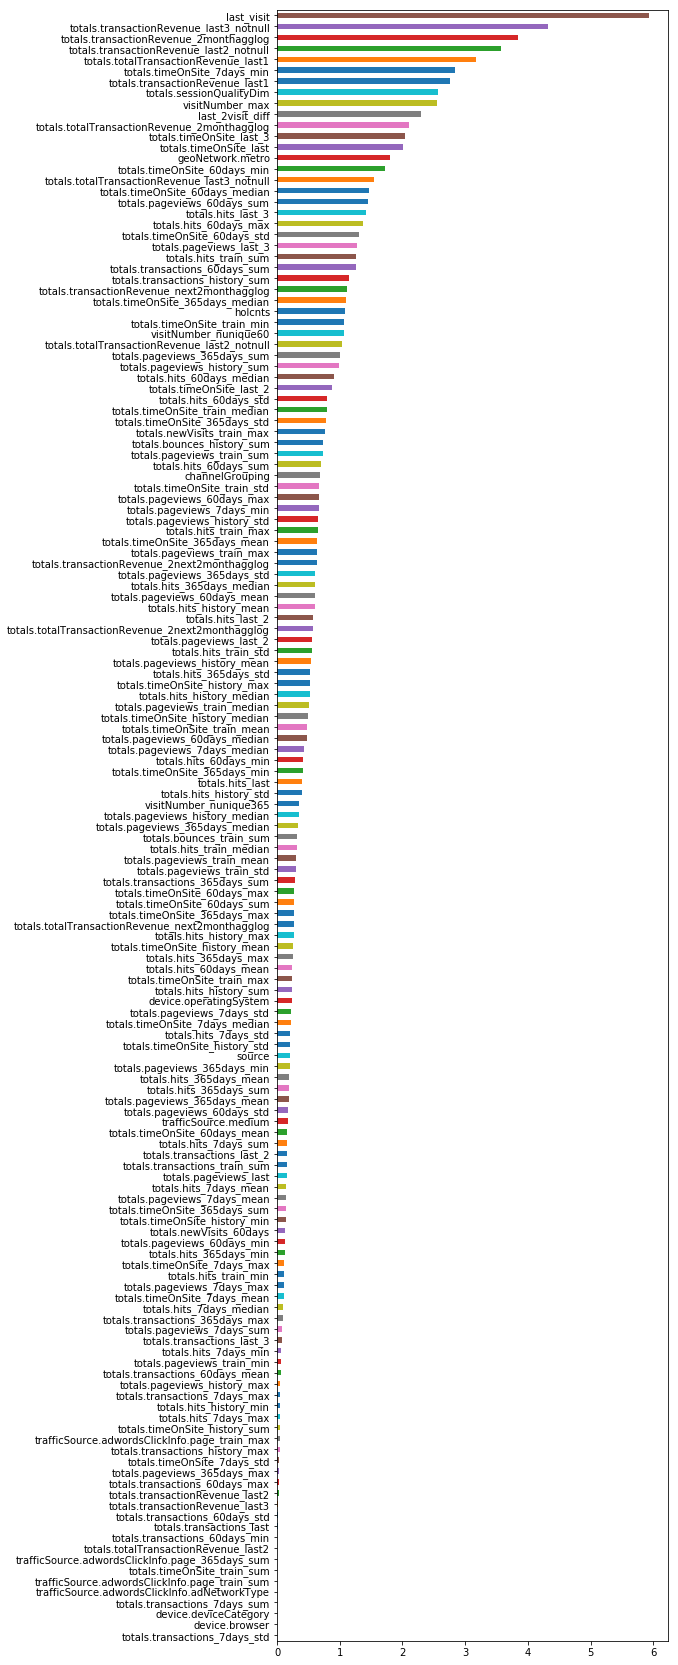

In [21]:
best_clf_features = pd.Series(model.feature_importances_, index=train_data.columns).sort_values()
treshold = 0
plt.figure(figsize=(7,30))
best_clf_features[best_clf_features>treshold].plot(kind='barh')
plt.show()

In [22]:
first_model = model

In [31]:
a = data[data['target']!=0]
b = data[data['target']==0].sample(a.shape[0]*10)

In [32]:
a.shape, b.shape

((1080, 217), (10800, 217))

In [33]:
d = pd.concat([a,b])

In [35]:
d.shape

(11880, 217)

In [36]:
train_data = d.drop(['target', 'fullVisitorId', 'block'], axis=1)
train_labels = d['target']
test_data = data_y.drop(['target', 'fullVisitorId', 'block'], axis=1)
test_labels = data_y['target']
cat_features = [idx for idx, col_type in enumerate(train_data.dtypes.values)
                if col_type=='object']
score = []

In [ ]:
depth = 15

# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=1000, learning_rate=0.03, depth=depth, loss_function='RMSE',
                          train_dir='catboostdir', od_type='Iter', od_wait=50, verbose=True)
# Fit model
model.fit(train_data, train_labels, cat_features)
# Get predictions
preds = model.predict(test_data)
score.append({'depth': depth, 'score': mean_squared_error(test_labels, preds)**0.5})
print(score[-1])

0:	learn: 5.3719760	total: 160ms	remaining: 2m 40s
1:	learn: 5.2913234	total: 331ms	remaining: 2m 45s
2:	learn: 5.2187216	total: 5.55s	remaining: 30m 46s
3:	learn: 5.1447437	total: 11.1s	remaining: 46m 3s
4:	learn: 5.0719464	total: 11.6s	remaining: 38m 36s
5:	learn: 5.0011515	total: 14.8s	remaining: 40m 47s
6:	learn: 4.9353890	total: 20.7s	remaining: 48m 55s
7:	learn: 4.8728799	total: 26.8s	remaining: 55m 21s
8:	learn: 4.8135520	total: 26.8s	remaining: 49m 11s
9:	learn: 4.7586844	total: 26.8s	remaining: 44m 16s
10:	learn: 4.7021064	total: 26.9s	remaining: 40m 15s
11:	learn: 4.6470651	total: 26.9s	remaining: 36m 57s
12:	learn: 4.5979155	total: 32.3s	remaining: 40m 52s
13:	learn: 4.5494683	total: 32.4s	remaining: 38m 3s
14:	learn: 4.5048465	total: 35.1s	remaining: 38m 24s
15:	learn: 4.4581752	total: 35.1s	remaining: 35m 59s
16:	learn: 4.4177037	total: 35.1s	remaining: 33m 52s
17:	learn: 4.3785038	total: 35.3s	remaining: 32m 3s
18:	learn: 4.3367350	total: 35.4s	remaining: 30m 28s
19:	lear

______